# INSY 6800 - EDA Project 

Project by Richie Wilbanks and Carly Walker

Project Description: Display EDA skills learned in INSY 6800 course by using a real world data set. The data set explored displays statistics for D1 NCAA Men's College Basketball teams ranging from 2010 to 2025. 

## Initial Data Setup 

In this section the data is imported from github, cleaned, and formatted into a dataframe so that the team can use the data for exploration. 

In [2]:
!pip install openpyxl
#Install to reach excel files 

In [3]:
#import pandas to handle DataFrames and Path for importing dataset
import pandas as pd
from pathlib import Path

#join current working directory to dataset
Project_Root = Path(".")
Data_Dir = Project_Root / "sports_data"

#import and sort excel files from dataset
excel_files = sorted(Data_Dir.glob("*.xls*"))

In [4]:
#Use function to load excel data for all seasons
def clean_season(path, season_name):

    # returns filename extension (.xls or .xlsx)
    ext = path.suffix.lower()

    # Run loop so function can support different file topes 
    if ext == ".xls":
        tables = pd.read_html(path, header=[0, 1])
        raw = tables[0]
    elif ext == ".xlsx":
        raw = pd.read_excel(path, header=[0, 1], engine="openpyxl")
    else:
        raise ValueError(f"Unsupported file type: {ext}")

    #Flatten column names 
    new_cols = []
    for col in raw.columns:
        # col is a tuple (ex: ("Overall", "W")
        if isinstance(col, tuple):
            top = str(col[0])
            sub = str(col[1])
        else:
            top = ""
            sub = str(col)

        # Cleaning data 
            #if school has no name
        if top.startswith("Unnamed") and sub == "School":
            name = "School"
        elif top == "Overall":
            # Tuples start with "Overall" but we want the sub header (ex: W, L, G)
            name = sub
        elif top == "Totals":
            # Tupes start with "Total" but we want sub header (ex: FG, 3P)
            name = sub
        elif top == "Points" and sub == "Tm.":
            #Make more readable 
            name = "PTS"
        elif top == "Points" and sub == "Opp.":
            #Make more readable 
            name = "Opp PTS"
        else:
            # For Conf., Home, Away, etc., create a unique name
            # that won't match keep_cols (so we ignore them)
            name = f"{top}_{sub}".strip()

        new_cols.append(name)

    raw.columns = new_cols

    #drop any completely empty columns
    raw = raw.dropna(axis=1, how="all")

    #Keep only wanted stats 
    keep_cols = [
        "School",
        "G", "W", "L", "W-L%", "SRS", "SOS",
        "PTS", "Opp PTS",
        "FG", "FGA", "FG%",
        "3P", "3PA", "3P%",
        "FT", "FTA", "FT%",
        "TRB", "AST", "STL", "BLK", "TOV"
    ]

    existing_cols = [col for col in keep_cols if col in raw.columns]
    missing_cols = [col for col in keep_cols if col not in raw.columns]

    #warning if column is missing 
    if missing_cols:
        print(f"For {season_name}, missing columns (skipped): {missing_cols}")

    df = raw[existing_cols].copy()

    #Remove duplicates 
    df = df.loc[:, ~df.columns.duplicated()]

    # Clean school names 
    if "School" in df.columns:
        df["School"] = (
            df["School"]
            .astype(str)
            .str.replace(r"\s*NCAA$", "", regex=True)
            .str.replace(r"\s*\(.*?\)", "", regex=True)
            .str.strip()
        )

    # Convert all numeric columns 
    for col in df.columns:
        if col != "School":
            #Ensures we are working with a series and not a data frame
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Add a season column
    df["Season"] = season_name

    return df

In [5]:
#Creates a dictionary with the season name (ex: 2010-2011) as key name and values as the dataframe from above 
season_dfs = {}

#Loop through excel files and strip so season name is the years 
for file in excel_files:
    name = file.stem
    season_name = name.split("_")[-1]  # ex: 2024-2025

    df_season = clean_season(file, season_name) # use fuction from above 
    season_dfs[season_name] = df_season

    #confirm the season was loaded 
    print("Loaded season:", season_name, "Shape:", df_season.shape)


Loaded season: 2010-2011 Shape: (345, 24)
Loaded season: 2011-2012 Shape: (344, 24)
Loaded season: 2012-2013 Shape: (347, 24)
Loaded season: 2013-2014 Shape: (351, 24)
Loaded season: 2014-2015 Shape: (351, 24)
Loaded season: 2015-2016 Shape: (351, 24)
Loaded season: 2016-2017 Shape: (351, 24)
Loaded season: 2017-2018 Shape: (351, 24)
Loaded season: 2018-2019 Shape: (353, 24)
Loaded season: 2019-2020 Shape: (353, 24)
Loaded season: 2020-2021 Shape: (347, 24)
Loaded season: 2021-2022 Shape: (358, 24)
Loaded season: 2022-2023 Shape: (363, 24)
Loaded season: 2023-2024 Shape: (363, 24)
Loaded season: 2024-2025 Shape: (364, 24)


In [6]:
#concatenate all cleaned seasons - create one data frame with all seasons data 
df_all = pd.concat(season_dfs.values(), ignore_index=True)
# remove rows with missing values
df_all = df_all.dropna().reset_index(drop=True)

## Question 1: Which team statistics have the strongest relationship with winning percentage? 

This question hopes to expose which factors have the strongest correlation with winning. For example, are teams with higher blocking stats winning more games?

In [24]:
#remove the columns that are win/lose percentages
exclude = ["W", "L", "W-L%"]

# Keep only stat columns (only numerical columns)
numeric_cols = [
    col for col in df_all.select_dtypes(include="number").columns
    if col not in exclude
]

correlation_data = df_all[numeric_cols].corrwith(df_all["W-L%"]).sort_values()

C:\Users\carly\AppData\Local\Temp\ipykernel_26880\3218933119.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_data.values, y=correlation_data.index, palette="coolwarm")


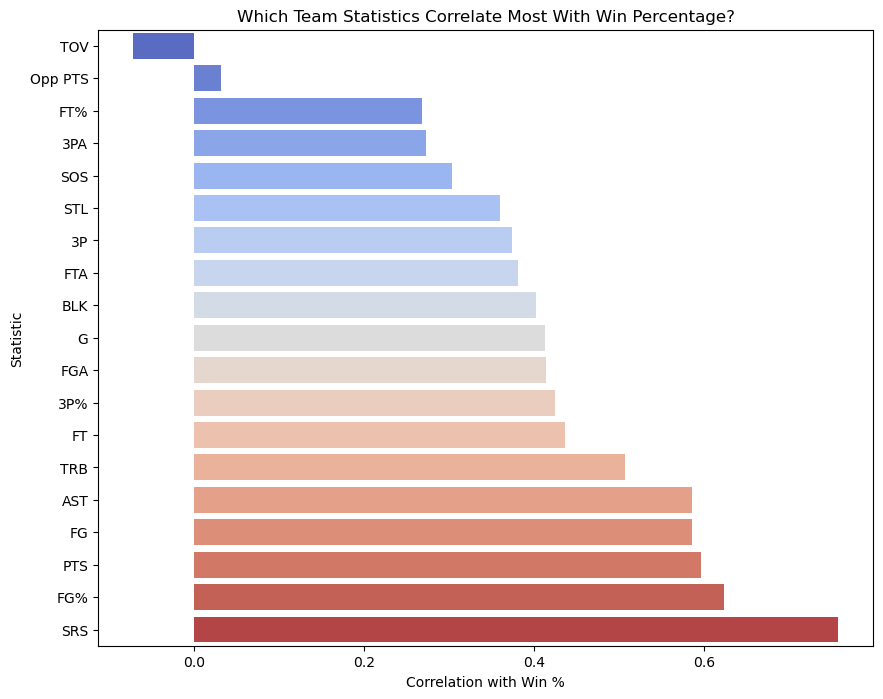

In [25]:
plt.figure(figsize=(10,8))
sns.barplot(x=correlation_data.values, y=correlation_data.index, palette="coolwarm")
plt.title("Which Team Statistics Correlate Most With Win Percentage?")
plt.xlabel("Correlation with Win %")
plt.ylabel("Statistic")
plt.show()

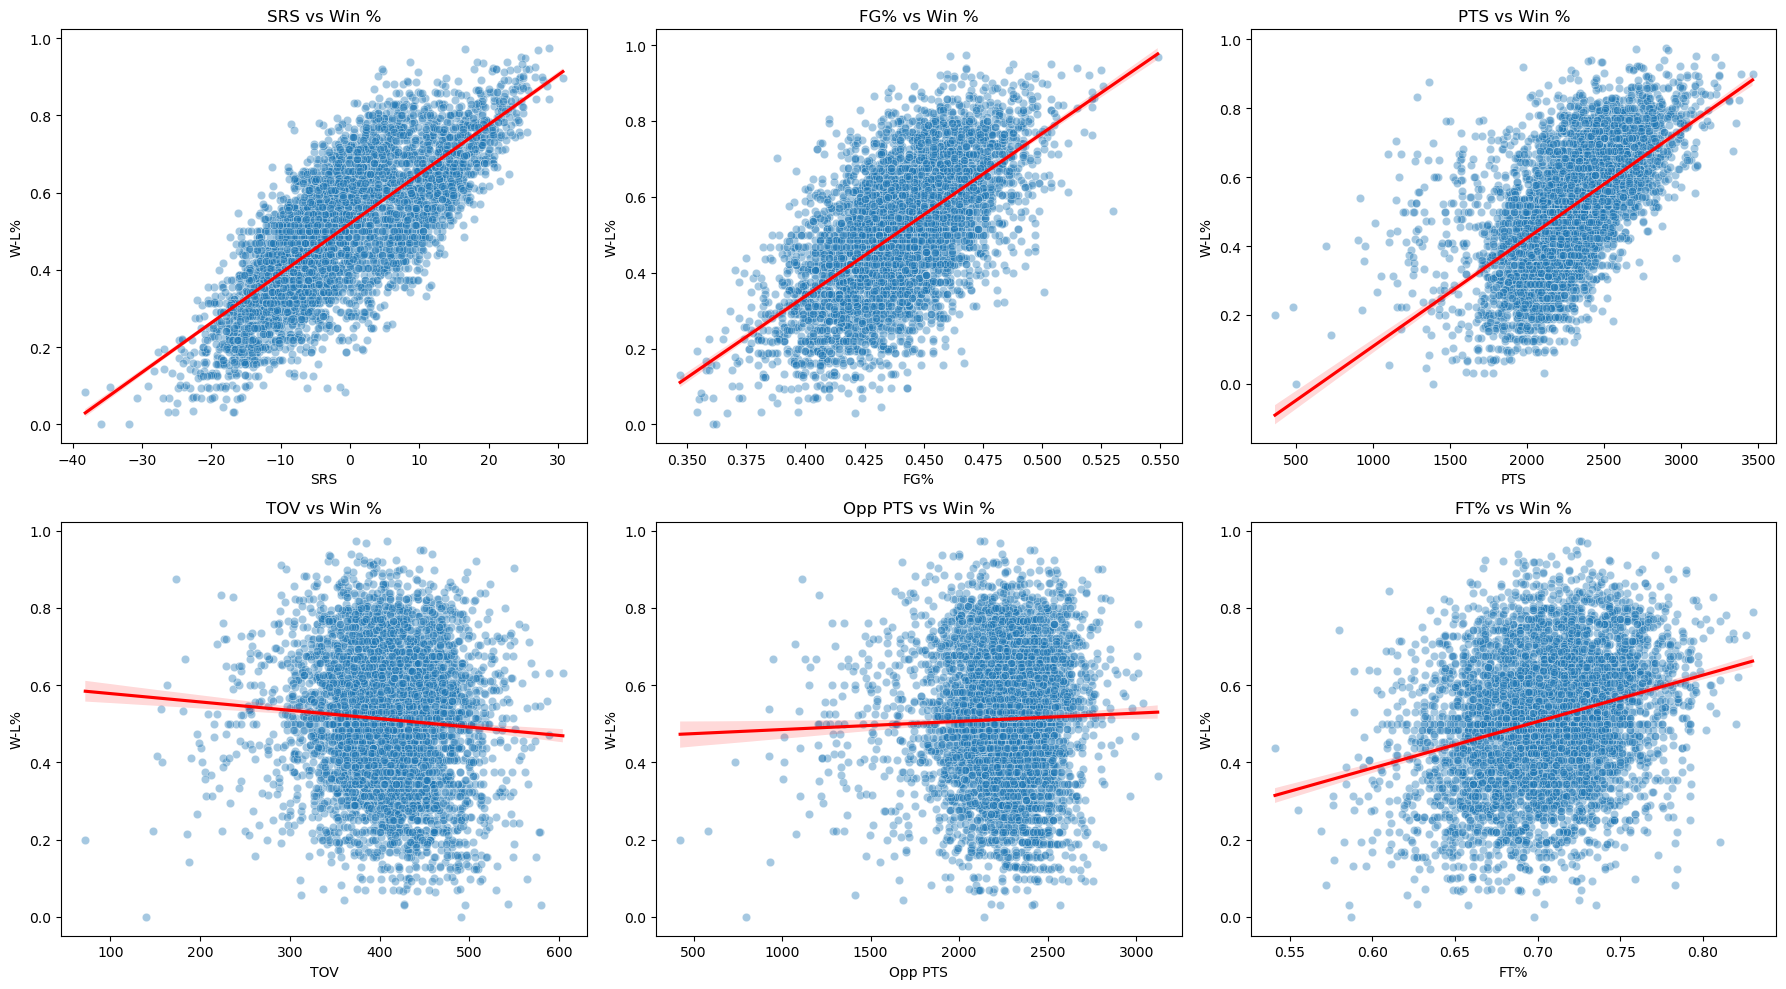

In [26]:
key_stats = ["SRS", "FG%", "PTS", "TOV", "Opp PTS", "FT%"]  # bottom 3 and top three stats

plt.figure(figsize=(18,10))

for i, stat in enumerate(key_stats, 1):
    plt.subplot(2, 3, i)  
    sns.scatterplot(data=df_all, x=stat, y="W-L%", alpha=0.4)
    sns.regplot(data=df_all, x=stat, y="W-L%", scatter=False, color="red")
    plt.title(f"{stat} vs Win %")

plt.tight_layout()
plt.show()

### Takeways: 

To find answers to the given question, "Which statistics best explain why certain teams win more games?", I first computed the correlations between each team stat and the teams win percentage. The first iteration of my graph included W, L, and W-L% but these factors directly showed wins and loses so I removed these from the analysis. This left the remaining numerical statistics which revealed certain factors as positive and negative associations with winning. For example, turnovers correlated negatively with win percentage and SRS (simple rating system), FG%, and total points scored all correlated positively. This shows that both offense and defense performance play a large role in helping a team succeed. 


Next, I graphed six of the key metrics: the 3 metrics on the bottom and top of the correlation list to show how the strongest psotive and negative correlations appear across all teams and seasons. The six scatterplots above show that a higher SRS, FG% and points scored all align with stronger win percentages and turnovers and opponents points trend downwards. This can help coaches and players to become aligned on there teams vision and find specific areas to focus on when preparing and playing. 

## Question 2: Are statistics shifting over time?

The goal of this question is to see if any of the statistics are shifting from season to season. For example, we can try to see if teams are shooting more 3 pointers, or if overall scoring is increasing or decreasing. 

In [9]:
#compute averages for each statistic per season
season_trends = df_all.groupby("Season").mean(numeric_only=True).reset_index()

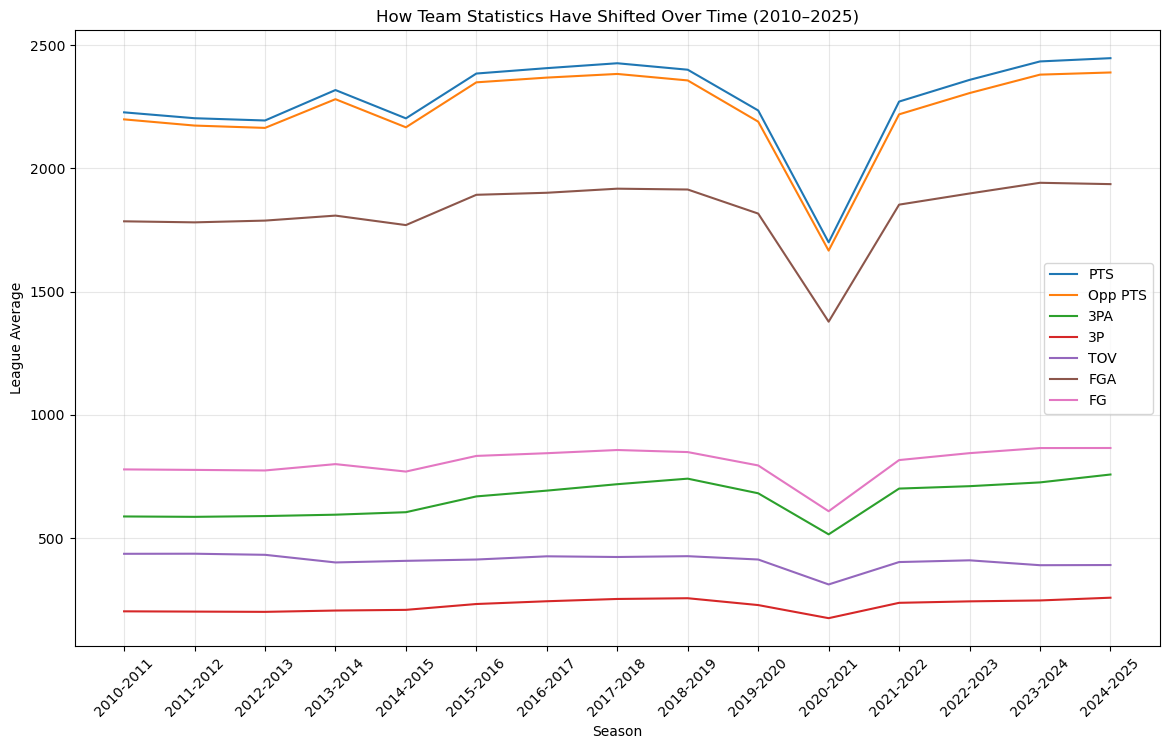

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#picked following stats to plot 
stats_to_plot = ["PTS", "Opp PTS", "3PA", "3P", "TOV", "FGA", "FG"]

plt.figure(figsize=(14, 8))

for stat in stats_to_plot:
    sns.lineplot(data=season_trends, x="Season", y=stat, label=stat)

plt.xticks(rotation=45)
plt.title("How Team Statistics Have Shifted Over Time (2010–2025)")
plt.ylabel("League Average")
plt.xlabel("Season")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

After seeing this plot it becomes clear that during the 2020-2021 season the averages where greatly affected due to Covid 19 and the modified season of college basketball. In order to see the averages without this dip I created the graph below that ignores the 2020-2021 season. 

In [11]:
#make a new variable which contains all seasons expect 2020-2021
season_trends_no_covid = season_trends[season_trends["Season"] != "2020-2021"]

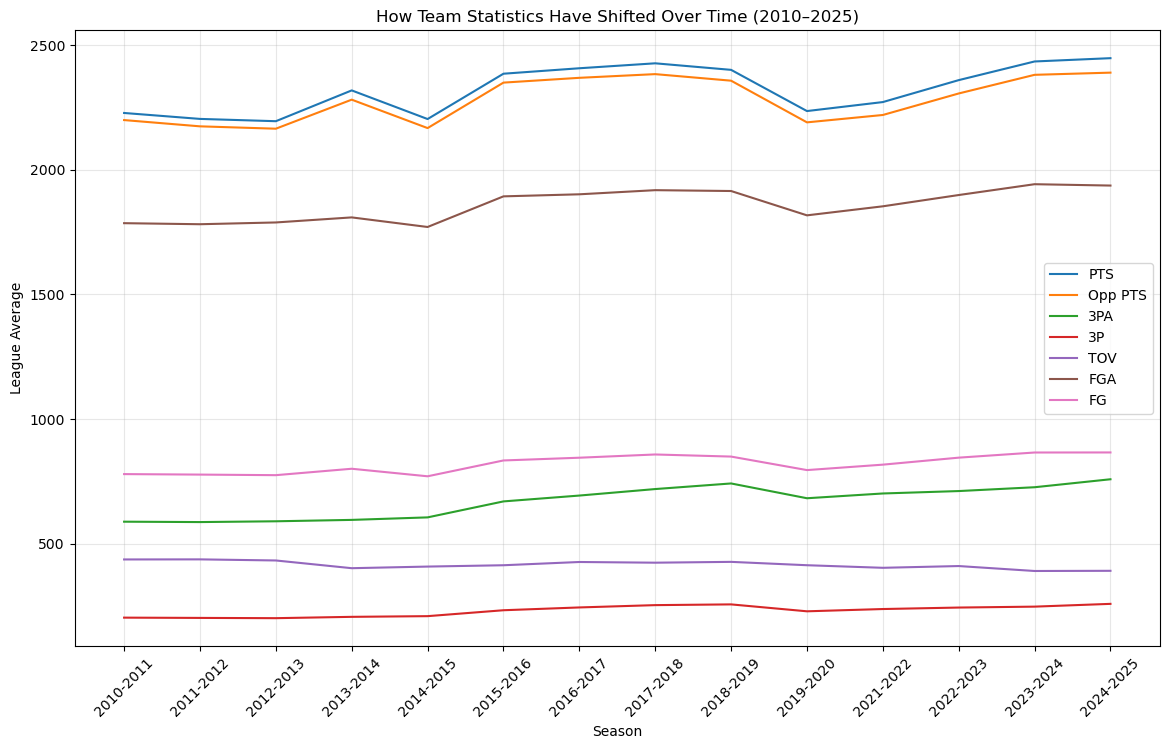

In [12]:
stats_to_plot = ["PTS", "Opp PTS", "3PA", "3P", "TOV", "FGA", "FG"]

plt.figure(figsize=(14, 8))

for stat in stats_to_plot:
    sns.lineplot(data=season_trends_no_covid, x="Season", y=stat, label=stat)

plt.xticks(rotation=45)
plt.title("How Team Statistics Have Shifted Over Time (2010–2025)")
plt.ylabel("League Average")
plt.xlabel("Season")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Takeaways

To analyze how league averages have shifted over time I used various key statistics, points, oppenent points, 3 point attempts, 3 points scored, turnovers, field goal attempts, and field goals scored. The first graph includes the 2020-2021 season and the second graph does not. I did this to show that the 2020-2021 season is an outlier due to the Covid-19 and the modified schedules. The second graph disregards the 2020-2021 season to show the more accurate trends across seasons. Additionally, I used the number of field goals and 3 pointers made instead of the percentage so that the lines on the graph were visable. At first I used the percentage and since some of the other values are so large the percentages looked like they were zero. These adjustments to the data/plots helped me draw concslusions about the trends over time. 


The plots above highlight that teams are attmepting and making more 3 pointers over time which is contributing to a gradual rise in overall scoring. Additionally, the end of the 2019-2020 season was the begining of Covid-19 which explains the slight decrease in overall averages. The lasting effect of the Covid-19 seasons is also shown by the effect of the 2021-2022 season. The leagues average in points scored is lower than 2015-2019 which could show the effect a season off/modified had on players and coaches. Additionally, turnovers have been showing a slight declone which could indicate improvements in ball handling and focus on offensive preparation. These factors can point towards the game moving towards a more offensive focused game that emphasizes higher scoring and more shot attempts versus defensive stops. 

## Question 3: Do certain SEC teams have statistical "signatures"? 

This question aims to answer if certain teams have a statistical signature. For example, does a team excel in making 3 point shots or in causing turnovers. I decided to compare teams within the SEC conference. 

In [14]:
#Selected teams: SEC Conference
sec_teams = [
    "Alabama",
    "Arkansas",
    "Auburn",
    "Florida",
    "Georgia",
    "Kentucky",
    "Louisiana State",
    "Mississippi State",
    "Mississippi",
    "Missouri",
    "South Carolina",
    "Tennessee",
    "Texas A&M",
    "Vanderbilt"
]

sec_df = df_all[df_all["School"].isin(sec_teams)].copy()
sec_df["School"].unique()


array(['Alabama', 'Arkansas', 'Auburn', 'Florida', 'Georgia', 'Kentucky',
       'Louisiana State', 'Mississippi', 'Mississippi State', 'Missouri',
       'South Carolina', 'Tennessee', 'Texas A&M', 'Vanderbilt'],
      dtype=object)

In [17]:
#pick columns to compate
sec_stat_cols = [ 
    "PTS", "Opp PTS",
    "FG%", "3P", "3PA", "FT%",
    "TRB", "AST", "STL", "BLK", "TOV",
    "SRS", "SOS"
]

#DF of columns with each SEC team
sec_team_stats = sec_df.groupby("School")[sec_stat_cols].mean()

In [19]:
#standardize the data using z scores 
#this way we can see realtive strengths and if teams are above/below in the SEC conference

sec_team_z = (sec_team_stats - sec_team_stats.mean()) / sec_team_stats.std()

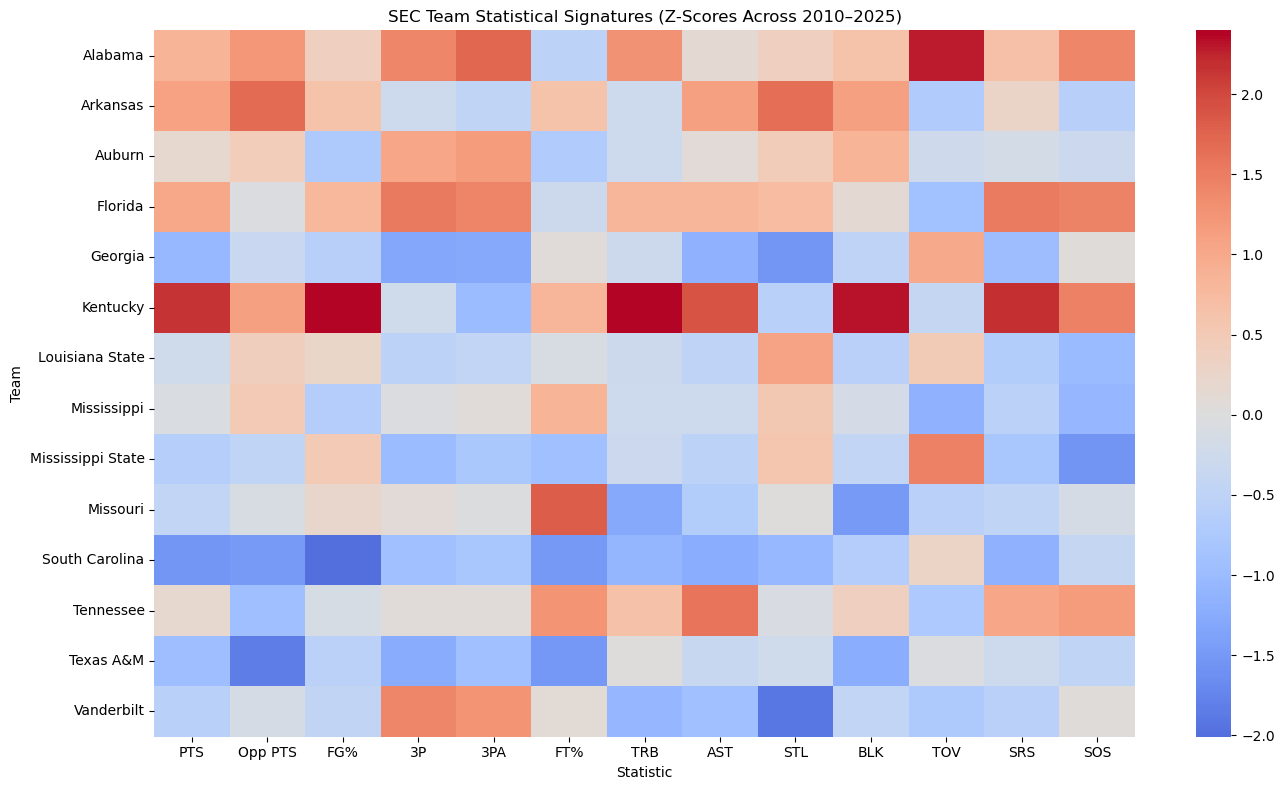

In [21]:
#make plot to show how each team compares to other SEC teams in given category
plt.figure(figsize=(14, 8))
sns.heatmap(
    sec_team_z,
    cmap="coolwarm",
    center=0,
    annot=False
)

plt.title("SEC Team Statistical Signatures (Z-Scores Across 2010–2025)")
plt.xlabel("Statistic")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


### Takeaways 

To explore whether teams in the SEC have distinct “statistical signatures,” I made a new dataframe only with the teams in the SEC conference. Then I computed the average in each of the given columns for all of the teams and standardized the findings using a z-score. I used z-scores and a heat map because the statistics beinf used vary highly in their values, for example, point sper season is in the thousands and blocks are around 50-150 per team. By using z-scores that allows us to compare these values realtively. The plot above highlights teams strengths and weaknesses relative to the average for the SEC conference. For example, Kentucky is well above the SEC averages for points scored, field goal percentage, total rebounds, assists, blocks, and SRS. Kentucky is a historically well established basketball school and this evidence proves there dominance in the SEC. Auburn is very middle of the pack based on this graph. in many of the categories Auburn is at average or very close to average. Some of the areas Auburn does best in include 3 point attempts and makes and some areas for improvement include field goal percentage, free throws, and turnovers. This plot highlights the meaningful differences between the way teams in the SEC play. This could be a helpful guide for coaches and players to see where their team excels and where improvements can be focused. 

## Question 4: Outliers or breakout seasons? (carly)

## Question 5: Richie

## Question 6: Richie

## Question 7: Richie

## Question 8: Richie 

## Takeaways/Conclusion: Richie 